In [22]:
from pathlib import Path

import geopandas as gpd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point

from data import constants
from data.eluc_data import ELUCData
import experiments.utils as utils
from prsdk.persistence.serializers.neural_network_serializer import NeuralNetSerializer
from prsdk.persistence.serializers.sklearn_serializer import SKLearnSerializer
from prescriptors.prescriptor_manager import PrescriptorManager
from prescriptors.heuristics.heuristics import EvenHeuristic, PerfectHeuristic
from predictors.percent_change.percent_change_predictor import PercentChangePredictor

## Setup

In [23]:
RESULTS_DIR = Path("prescriptors/nsga2/training_runs/eds")
FIGURE_DIR = Path("experiments/figures/eds")
OUTCOMES = ["ELUC", "change"]

In [24]:
dataset = ELUCData.from_hf()
encoder = dataset.encoder

test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = encoder.encode_as_df(test_df)

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

## Generate Results

In [25]:
nn_serializer = NeuralNetSerializer()
nnp = nn_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-nn"))
change_predictor = PercentChangePredictor()
predictors = {"ELUC": nnp, "change": change_predictor}

evolved_results = utils.heuristics.evaluate_experiment(RESULTS_DIR, 100, context_df, encoder, OUTCOMES, predictors)

100%|██████████| 228/228 [01:31<00:00,  2.48it/s]


In [26]:
pcts = [i / 100 for i in range(0, 101)]

linreg_serializer = SKLearnSerializer()
linreg = linreg_serializer.load(Path("predictors/trained_models/danyoung--eluc-global-linreg"))
coefs = linreg.model.coef_
coef_dict = dict(zip(constants.LAND_USE_COLS, coefs))
reco_coefs = []
for col in constants.RECO_COLS:
    reco_coefs.append(coef_dict[col])

even_manager = PrescriptorManager({str(pct): EvenHeuristic(pct, "secdf") for pct in pcts}, predictors)
perfect_manager = PrescriptorManager({str(pct): PerfectHeuristic(pct, reco_coefs) for pct in pcts}, predictors)

In [27]:
even_results = utils.heuristics.evaluate_prescriptors(even_manager, [str(pct) for pct in pcts], context_df, OUTCOMES)
perfect_results = utils.heuristics.evaluate_prescriptors(perfect_manager, [str(pct) for pct in pcts], context_df, OUTCOMES)

100%|██████████| 101/101 [16:06<00:00,  9.57s/it]


## Compare Pareto Fronts

In [28]:
def compare_paretos(ax: plt.Axes, results_dfs: list[pd.DataFrame], plot_params: list[dict]):
    for results_df, params in zip(results_dfs, plot_params):
        results_df = results_df.sort_values(by="change")
        ax.scatter(results_df["change"], results_df["ELUC"], **params)

    ax.legend()
    ax.set_xlabel("Change")
    ax.set_ylabel("ELUC")
    ax.set_title("Pareto Fronts of Evolved Prescriptors vs. Heuristics")
    return ax

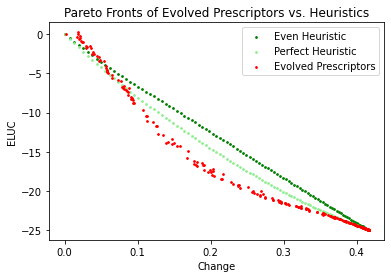

In [29]:
pareto_params = [
    {"label": "Even Heuristic", "color": "green", "s": 3},
    {"label": "Perfect Heuristic", "color": "lightgreen", "s": 3},
    {"label": "Evolved Prescriptors", "color": "red", "s": 3}
]

fig, ax = plt.subplots()
ax = compare_paretos(ax, [even_results, perfect_results, evolved_results], pareto_params)
plt.show()

## Hypervolume

In [30]:
def compare_hypervolumes(results_dfs: list[pd.DataFrame], ref_point: np.ndarray, ideal: np.ndarray, outcomes: list[str]):
    for results_df in results_dfs:
        print(utils.heuristics.get_hypervolume(results_df, ref_point, ideal, outcomes))

In [31]:
min_eluc = perfect_results["ELUC"].min()
max_change = perfect_results["change"].max()
ref_point = np.array([0, max_change])
ideal = np.array([min_eluc, 0])
compare_hypervolumes([even_results, perfect_results, evolved_results], ref_point, ideal, OUTCOMES)

0.511525882094481
0.565961368808071
0.6155600581705464


## Individual Point Analysis

In [32]:
evolved_results[(evolved_results["change"] > 0.15) & (evolved_results["change"] < 0.2)]

,ELUC,change,cand_id
76,-17.285700,0.198739,57_14
131,-14.885287,0.169141,81_65
133,-16.329813,0.181384,81_6
145,-17.540516,0.197067,83_61
159,-15.758337,0.167258,87_15
164,-16.799408,0.181462,88_31
168,-16.108809,0.176932,89_41
172,-16.719055,0.190098,90_13
186,-16.399937,0.188542,92_43
187,-16.693825,0.191218,92_12


In [33]:
evolved_id = "83_61"
change = evolved_results[evolved_results["cand_id"] == evolved_id]["change"].values[0]

even_id = utils.heuristics.closest_cand_id(even_results, change)
perfect_id = utils.heuristics.closest_cand_id(perfect_results, change)

In [34]:
def plot_selected_points(ax: plt.Axes, results_dfs: list[pd.DataFrame], cand_ids: list[str], plot_params: list[dict]):
    for results_df, cand_id, params in zip(results_dfs, cand_ids, plot_params):
        filtered_df = results_df[results_df["cand_id"] == cand_id]
        ax.scatter(filtered_df["change"], filtered_df["ELUC"], **params)
        print(filtered_df["change"].iloc[0], filtered_df["ELUC"].iloc[0])
    ax.set_xlim(results_dfs[0]["change"].min(), results_dfs[0]["change"].max())
    ax.set_ylim(results_dfs[0]["ELUC"].min(), results_dfs[0]["ELUC"].max())
    ax.set_xlabel("Change")
    ax.set_ylabel("ELUC")
    ax.set_title("a) Selected Points' Average Performance")
    ax.legend()
    return ax

0.19841195847705592 -12.386484
0.19841195847705592 -14.454385
0.19706665064637213 -17.540516


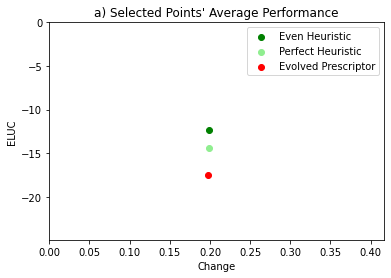

In [35]:
selected_params = [
    {"label": "Even Heuristic", "color": "green"},
    {"label": "Perfect Heuristic", "color": "lightgreen"},
    {"label": "Evolved Prescriptor", "color": "red"}
]
fig, ax = plt.subplots()
ax = plot_selected_points(ax, [even_results, perfect_results, evolved_results], [even_id, perfect_id, evolved_id], selected_params)
plt.show()

In [36]:
evolved_manager = utils.heuristics.create_experiment_manager(RESULTS_DIR, 100, predictors, encoder, OUTCOMES)
evolved_cao = utils.heuristics.trained_prescribe_and_predict(evolved_manager, evolved_id, context_df)
even_cao = utils.heuristics.trained_prescribe_and_predict(even_manager, even_id, context_df)
perfect_cao = utils.heuristics.trained_prescribe_and_predict(perfect_manager, perfect_id, context_df)

In [37]:
def plot_map(ax: plt.Axes, evolved_cao: pd.DataFrame, perfect_cao: pd.DataFrame):
    geo_df = evolved_cao.copy()
    geo_df = geo_df[geo_df["time"] == 2021]
    geo_df["change_diff"] = evolved_cao["change"] - perfect_cao["change"]

    min_max = max(abs(geo_df["change_diff"].min()), abs(geo_df["change_diff"].max()))
    norm = TwoSlopeNorm(vmin=-1 * min_max, vcenter=0, vmax=min_max)

    geo_df.loc[:,"geometry"] = geo_df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
    geo_df = gpd.GeoDataFrame(geo_df, geometry="geometry")
    geo_df.set_crs(epsg=4326, inplace=True)
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    world.plot(ax=ax, color='lightgrey')
    ax.scatter(geo_df.geometry.x, geo_df.geometry.y, c=geo_df["change_diff"], cmap="PiYG", norm=norm, s=5)
    ax.figure.colorbar(ScalarMappable(norm=norm, cmap="PiYG"), ax=ax, label="Amount Change Difference", shrink=0.5)
    ax.set_title("b) Difference in Change Between Evolved and Perfect Heuristic")
    ax.set_aspect("auto")
    return ax

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_34325/3353244215.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


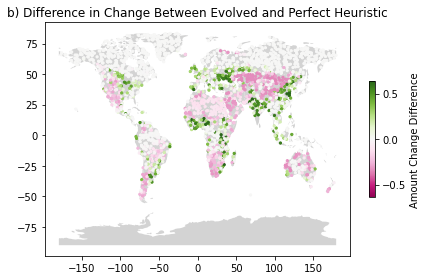

In [38]:
fig, ax = plt.subplots(tight_layout=True)
ax = plot_map(ax, evolved_cao, perfect_cao)
plt.show()

In [39]:
evolved_sample = evolved_cao.sample(frac=0.1, random_state=42)
even_sample = even_cao.loc[evolved_sample.index]
perfect_sample = perfect_cao.loc[evolved_sample.index]

In [40]:
def plot_expanded(ax: plt.Axes, cao_dfs: list[pd.DataFrame], plot_params=list[dict]):

    for cao_df, params in zip(cao_dfs, plot_params):
        ax.scatter(cao_df["change"], cao_df["ELUC"], **params)

    # Order legend how we want: even, perfect, evolved
    # Order it's coming in: even, evolved, perfect
    handles, labels = ax.get_legend_handles_labels()
    order = [0, 2, 1]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

    ax.set_title("b) Performance on Underlying Samples")
    ax.set_xlabel("Change")
    ax.set_ylabel("ELUC")
    return ax

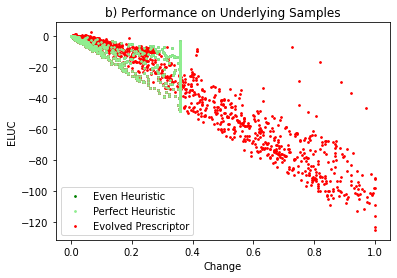

In [41]:
plot_params = [
    {"label": "Even Heuristic", "color": "green", "s": 3},
    {"label": "Evolved Prescriptor", "color": "red", "s": 3},
    {"label": "Perfect Heuristic", "color": "lightgreen", "s": 3}
]
fig, ax = plt.subplots()
ax = plot_expanded(ax, [even_sample, evolved_sample, perfect_sample], plot_params)
plt.show()

In [42]:
def plot_diffs(ax: plt.Axes, evolved_cao: pd.DataFrame, perfect_cao: pd.DataFrame, verbose=False):

    diff_df = evolved_cao.copy()
    diff_df["change"] = evolved_cao["change"] - perfect_cao["change"]
    diff_df["ELUC"] = evolved_cao["ELUC"] - perfect_cao["ELUC"]

    dom = diff_df[(diff_df["change"] < 0) & (diff_df["ELUC"] < 0)]
    other_dom = diff_df[(diff_df["change"] > 0) & (diff_df["ELUC"] > 0)]

    if verbose:
        print(dom)

    ax.scatter(diff_df["change"], diff_df["ELUC"], label="No domination", s=3, color="gray")
    ax.scatter(other_dom["change"], other_dom["ELUC"], color="lightgreen", label="Perfect Heuristic dominates", s=3)
    ax.scatter(dom["change"], dom["ELUC"], color="red", label="Evolved Prescriptor dominates", s=3)
    ax.axhline(0, color="black", linestyle="--")
    ax.axvline(0, color="black", linestyle="--")
    ax.set_xlabel("Change Difference")
    ax.set_ylabel("ELUC Difference")
    ax.set_title("c) Performance Differences")
    
    ax.legend()
    return ax

                              crop  pastr  primf     primn     range  secdf  \
time_idx lat_idx lon_idx                                                      
2018     36.875  75.375   0.000429    0.0    0.0  0.004723  0.158792    0.0   

                             secdn  urban     cell_area     lat  ...  \
time_idx lat_idx lon_idx                                         ...   
2018     36.875  75.375   0.463678    0.0  61817.378906  36.875  ...   

                          crop_diff  pastr_diff  primf_diff  primn_diff  \
time_idx lat_idx lon_idx                                                  
2018     36.875  75.375   -0.000429         0.0           0           0   

                          range_diff  secdf_diff  secdn_diff  urban_diff  \
time_idx lat_idx lon_idx                                                   
2018     36.875  75.375    -0.043538    0.198522   -0.154555           0   

                              ELUC    change  
time_idx lat_idx lon_idx                   

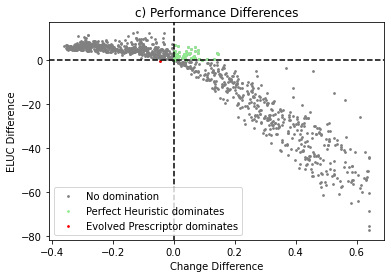

In [43]:
fig, ax = plt.subplots()
ax = plot_diffs(ax, evolved_sample, perfect_sample, verbose=True)
plt.show()

In [44]:
def plot_avg_presc(ax: plt.Axes, cao_dfs: list[pd.DataFrame], plot_params: list[dict], save_path=None):
    xticks = np.arange(len(constants.DIFF_RECO_COLS))
    i = 0
    width = 1 / (len(cao_dfs) + 1)
    for cao_df, params in zip(cao_dfs, plot_params):
        ax.bar(xticks + i * width, cao_df[constants.DIFF_RECO_COLS].mean(), width=width, **params)
        i += 1
    
    ax.set_xticks(xticks + (len(cao_dfs)-1)/2 * width, constants.DIFF_RECO_COLS, rotation=90)
    ax.grid()
    ax.legend()
    ax.set_title("a) Average Recommendations Comparison")
    return ax

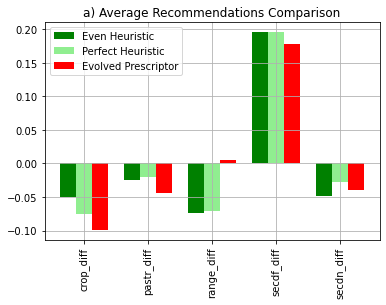

In [45]:
avg_presc_params = [
    {"label": "Even Heuristic", "color": "green"},
    {"label": "Perfect Heuristic", "color": "lightgreen"},
    {"label": "Evolved Prescriptor", "color": "red"}
]
fig, ax = plt.subplots()
ax = plot_avg_presc(ax, [even_cao, perfect_cao, evolved_cao], avg_presc_params)
plt.show()

### Final Paper Figures

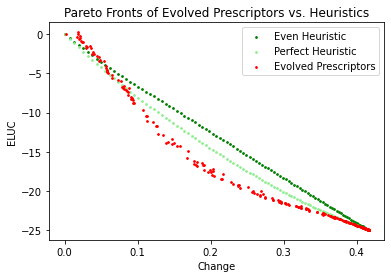

In [46]:
fig, ax = plt.subplots()
ax = compare_paretos(ax, [even_results, perfect_results, evolved_results], pareto_params)
plt.savefig(FIGURE_DIR / "heuristic-fig.png", dpi=300, format="png")
plt.show()

0.19841195847705592 -12.386484
0.19841195847705592 -14.454385
0.19706665064637213 -17.540516


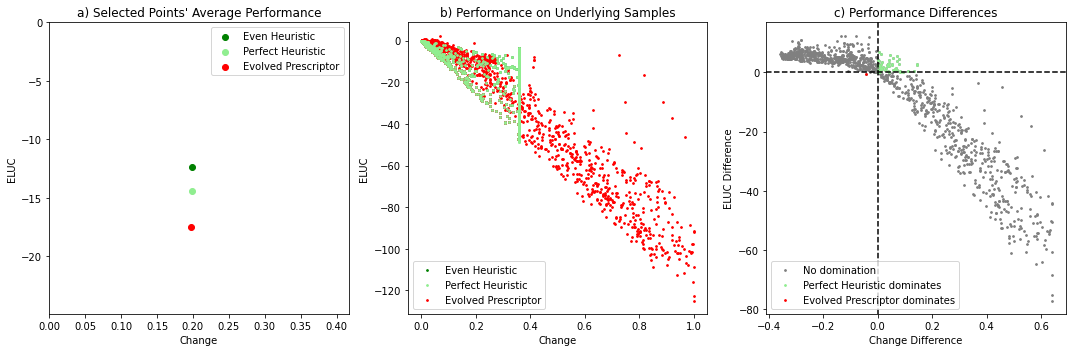

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
axes[0] = plot_selected_points(axes[0], [even_results, perfect_results, evolved_results], [even_id, perfect_id, evolved_id], selected_params)
axes[1] = plot_expanded(axes[1], [even_sample, evolved_sample, perfect_sample], plot_params)
axes[2] = plot_diffs(axes[2], evolved_sample, perfect_sample)
plt.savefig(FIGURE_DIR / "expand-fig.png", dpi=300, format="png")
plt.show()

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_20629/3353244215.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


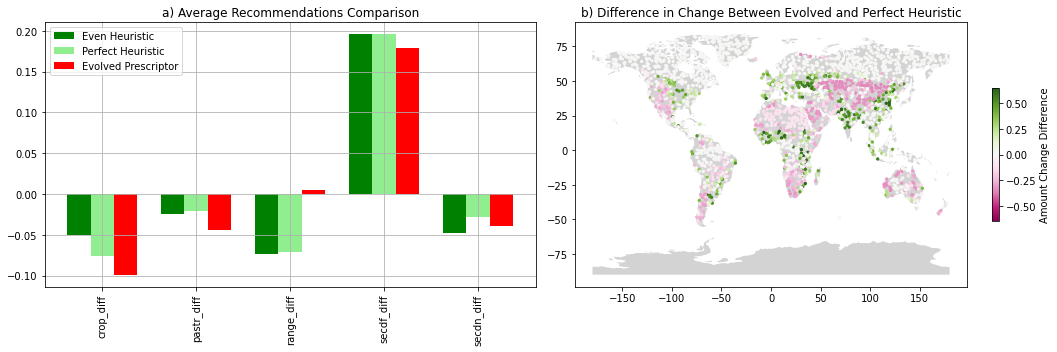

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
axes[0] = plot_avg_presc(axes[0], [even_cao, perfect_cao, evolved_cao], avg_presc_params)
axes[1] = plot_map(axes[1], evolved_cao, perfect_cao)
plt.savefig(FIGURE_DIR / "examine-fig.png", dpi=300, format="png")
plt.show()